In [1]:
import torch
import numpy as np
from tqdm import tqdm
import multiprocessing

In [5]:
# The MNIST datasets are hosted on yann.lecun.com that has moved under CloudFlare protection
# Run this script to enable the datasets download
# Reference: https://github.com/pytorch/vision/issues/1938

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [7]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
# We set this equal to the number of CPUs available
# in this machine
num_workers = multiprocessing.cpu_count()

# how many samples per batch to load. You can experiment
# with this parameter to try to improve performances
batch_size = 64

# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [
        # This transforms takes a np.array or a PIL image of integers
        # in the range 0-255 and transforms it to a float tensor in the
        # range 0.0 - 1.0
        transforms.ToTensor(),
        # This then renormalize the tensor to be between -1.0 and 1.0,
        # which is a better range for modern activation functions like
        # Relu
        transforms.Normalize((0.5), (0.5)),
    ]
)


# Get train, validation and test

# Let's start with train and validation
trainval_data = datasets.MNIST(
    root="data", train=True, download=True, transform=transform
)

# Split in train and validation
# NOTE: we set the generator with a fixed random seed for reproducibility
train_len = int(len(trainval_data) * 0.8)
val_len = len(trainval_data) - train_len
print(f"Using {train_len} examples for training and {val_len} for validation")
train_subset, val_subset = torch.utils.data.random_split(
    trainval_data, [train_len, val_len], generator=torch.Generator().manual_seed(42)
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_subset, shuffle=True, batch_size=batch_size, num_workers=num_workers
)
val_loader = torch.utils.data.DataLoader(
    dataset=val_subset, shuffle=False, batch_size=batch_size, num_workers=num_workers
)

# Get test data
test_data = datasets.MNIST(root="data", train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, num_workers=num_workers
)
print(f"Using {len(test_data)} for testing")

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Using 48000 examples for training and 12000 for validation
Using 10000 for testing


### Visualize a Batch of Training Data

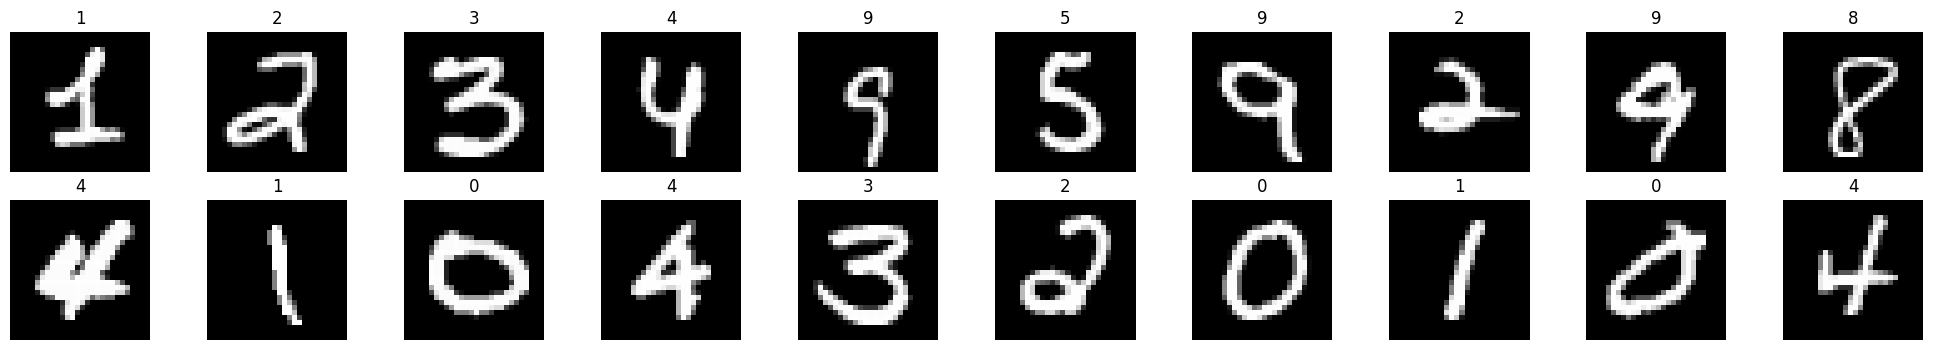

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig, subs = plt.subplots(2, 10, figsize=(25, 4))
for idx, sub in zip(np.arange(20), subs.flatten()):
    sub.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    sub.set_title(str(labels[idx].item()))
    sub.axis("off")

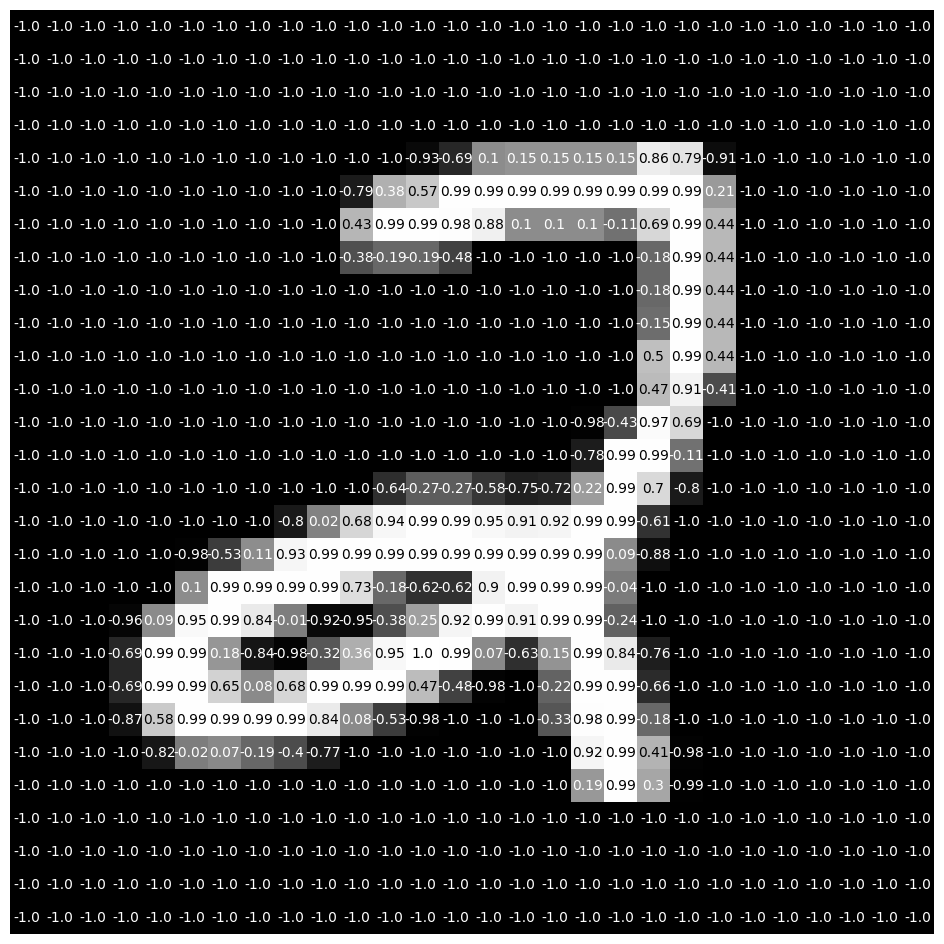

In [11]:
img = np.squeeze(images[1])

fig, sub = plt.subplots(figsize = (12,12)) 
sub.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        sub.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')
        sub.axis("off")

In [12]:
import torch.nn as nn
import torch.nn.functional as F

## TODO: Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 400),
            nn.Dropout(0.5),
            nn.ReLU(),
            # Hidden layer
            nn.Linear(400, 400),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(400, 10)
        )

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        
        return self.model(x)
        

# initialize the NN
model = Net()

# NOTE: this is NOT the structure of the network, but merely a
# visualization of the layers that are present. For very simple
# architectures the two might be similar, but for more complicated
# network they will not. See the next cell for a possible way of
# visualizing the real structure of the network
print(model)

Net(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=400, out_features=400, bias=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=400, out_features=10, bias=True)
  )
)


In [14]:
# run this to visualize defined architecture on Netron.app
#scripted = torch.jit.script(model)
#torch.jit.save(scripted, "mnist_network.pt")

###  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

It's recommended that you use cross-entropy loss for classification. If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a softmax function to the output layer *and* then calculates the log loss.

In [16]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0)

---
## Train the Network

1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

The following loop trains for 50 epochs; feel free to change this number. For now, we suggest somewhere between 20-50 epochs. As you train, take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data. 

In [17]:
# number of epochs to train the model
n_epochs = 30  # suggest training between 20-50 epochs

model.train() # prep model for training

for epoch in range(n_epochs):
    train_loss = 0.0
    
    for batch_idx, (data, target) in tqdm(
        enumerate(train_loader),
        desc="Training",
        total=len(train_loader),
        leave=True,
        ncols=80
    ):
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    
    # Validate
    with torch.no_grad():

        # set the model to evaluation mode
        model.eval()

        valid_loss = 0.0
        for batch_idx, (data, target) in tqdm(
            enumerate(val_loader),
            desc="Validating",
            total=len(val_loader),
            leave=True,
            ncols=80,
        ):
            # 1. forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)  # =
            # 2. calculate the loss
            loss_value = criterion(output, target)
            # Calculate average validation loss
            valid_loss = valid_loss + (
                (1 / (batch_idx + 1)) * (loss_value.data.item() - valid_loss)
            )
    
    print(f"Epoch {epoch+1}: training loss {train_loss:.5f}, valid loss {valid_loss:.5f}")

Validating: 100%|█████████████████████████████| 188/188 [00:01<00:00, 94.27it/s]

Epoch 1: training loss 1.35201, valid loss 0.54045



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 65.95it/s]

Epoch 2: training loss 0.40917, valid loss 0.36433



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 82.42it/s]

Epoch 3: training loss 0.32801, valid loss 0.32836



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 65.74it/s]

Epoch 4: training loss 0.28973, valid loss 0.29225



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 91.74it/s]

Epoch 5: training loss 0.26156, valid loss 0.27554



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 65.29it/s]

Epoch 6: training loss 0.23806, valid loss 0.24911



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 64.13it/s]

Epoch 7: training loss 0.21740, valid loss 0.23045



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 88.86it/s]

Epoch 8: training loss 0.19826, valid loss 0.20971



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 70.04it/s]

Epoch 9: training loss 0.18226, valid loss 0.19792



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 70.10it/s]

Epoch 10: training loss 0.16808, valid loss 0.18691



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 70.52it/s]

Epoch 11: training loss 0.15554, valid loss 0.18308



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 69.58it/s]

Epoch 12: training loss 0.14485, valid loss 0.16389



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 73.80it/s]

Epoch 13: training loss 0.13491, valid loss 0.15753



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 90.78it/s]

Epoch 14: training loss 0.12580, valid loss 0.15213



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 90.13it/s]

Epoch 15: training loss 0.11834, valid loss 0.14434



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 93.67it/s]

Epoch 16: training loss 0.11114, valid loss 0.13766



Validating: 100%|█████████████████████████████| 188/188 [00:01<00:00, 95.67it/s]

Epoch 17: training loss 0.10473, valid loss 0.13418



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 90.11it/s]

Epoch 18: training loss 0.09888, valid loss 0.12801



Validating: 100%|█████████████████████████████| 188/188 [00:01<00:00, 94.99it/s]

Epoch 19: training loss 0.09316, valid loss 0.12545



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 89.36it/s]

Epoch 20: training loss 0.08873, valid loss 0.12411



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 90.75it/s]

Epoch 21: training loss 0.08394, valid loss 0.11869



Validating: 100%|█████████████████████████████| 188/188 [00:01<00:00, 95.59it/s]

Epoch 22: training loss 0.07926, valid loss 0.11669



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 92.49it/s]

Epoch 23: training loss 0.07566, valid loss 0.11141



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 90.86it/s]

Epoch 24: training loss 0.07179, valid loss 0.10911



Validating: 100%|█████████████████████████████| 188/188 [00:02<00:00, 92.44it/s]

Epoch 25: training loss 0.06832, valid loss 0.10974



Validating: 100%|█████████████████████████████| 188/188 [00:01<00:00, 95.84it/s]

Epoch 26: training loss 0.06537, valid loss 0.10831



Validating: 100%|█████████████████████████████| 188/188 [00:01<00:00, 95.34it/s]

Epoch 27: training loss 0.06225, valid loss 0.10773



Validating: 100%|█████████████████████████████| 188/188 [00:01<00:00, 95.21it/s]

Epoch 28: training loss 0.05984, valid loss 0.09969



Validating: 100%|█████████████████████████████| 188/188 [00:01<00:00, 95.20it/s]

Epoch 29: training loss 0.05672, valid loss 0.10100



Validating: 100%|█████████████████████████████| 188/188 [00:01<00:00, 97.13it/s]

Epoch 30: training loss 0.05422, valid loss 0.09965


## Test the Trained Network
#### `model.eval()`

`model.eval(`) will set all the layers in your model to evaluation mode. This affects layers like dropout layers that turn "off" nodes during training with some probability, but should allow every node to be "on" for evaluation!

In [18]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0.0 for i in range(10))
class_total = list(0.0 for i in range(10))

model.eval()  # prep model for *evaluation*

for batch_idx, (data, target) in tqdm(
    enumerate(test_loader),
    desc="Testing",
    total=len(test_loader),
    leave=True,
    ncols=80,
):
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss
    test_loss += loss.item() * data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(data.shape[0]):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.6f}\n")

for i in range(10):
    if class_total[i] > 0:
        print(
            f"Test Accuracy of {i}: {100 * class_correct[i] / class_total[i]:.2f}%% "
            f"({int(np.sum(class_correct[i]))}/{int(np.sum(class_total[i]))})"
        )
    else:
        print(f"Test Accuracy of {classes[i]}: N/A (no training examples)")

print(
    f"\nTest Accuracy (Overall): {100.0 * np.sum(class_correct) / np.sum(class_total)}%% "
    f"({int(np.sum(class_correct))}/{int(np.sum(class_total))})"
)

Testing: 100%|████████████████████████████████| 157/157 [00:02<00:00, 76.25it/s]

Test Loss: 0.084075

Test Accuracy of 0: 98.27%% (963/980)
Test Accuracy of 1: 99.12%% (1125/1135)
Test Accuracy of 2: 97.48%% (1006/1032)
Test Accuracy of 3: 97.62%% (986/1010)
Test Accuracy of 4: 97.35%% (956/982)
Test Accuracy of 5: 98.43%% (878/892)
Test Accuracy of 6: 97.29%% (932/958)
Test Accuracy of 7: 95.43%% (981/1028)
Test Accuracy of 8: 97.43%% (949/974)
Test Accuracy of 9: 95.94%% (968/1009)

Test Accuracy (Overall): 97.44%% (9744/10000)


### Visualize Sample Test Results

This cell displays test images and their labels in this format: `predicted (ground-truth)`. The text will be green for accurately classified examples and red for incorrect predictions.

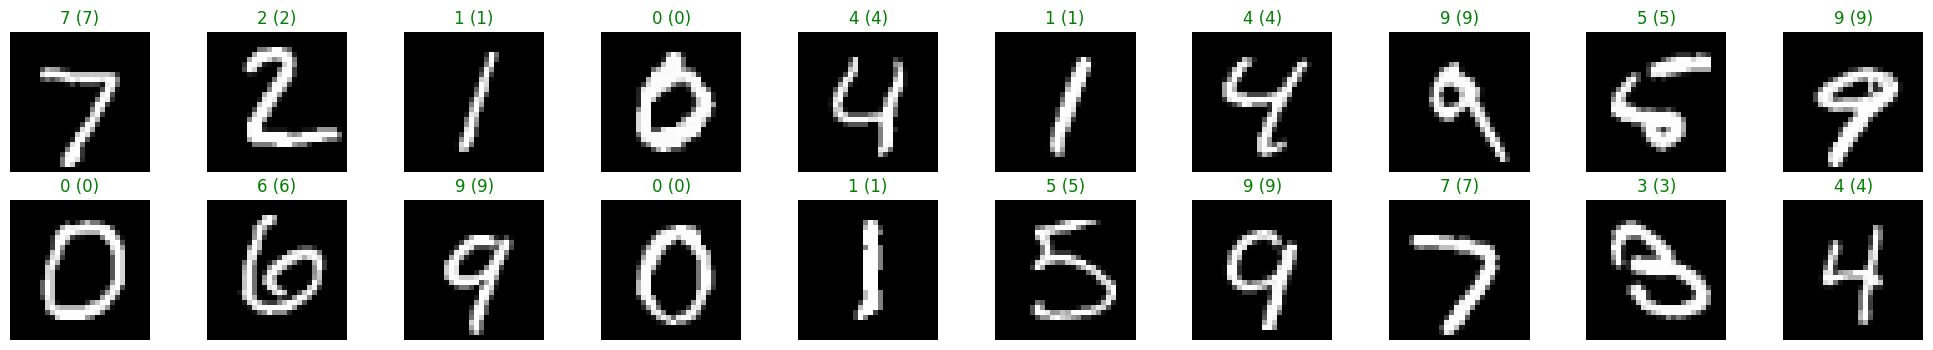

In [22]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig, subs = plt.subplots(2, 10, figsize=(25, 4))
for idx, sub in zip(range(20), subs.flatten()):
    sub.imshow(np.squeeze(images[idx]), cmap='gray')
    sub.set_title(f"{str(preds[idx].item())} ({str(labels[idx].item())})",
                 color=("green" if preds[idx]==labels[idx] else "red"))
    sub.axis("off")